In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import optuna
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima


from utils import (
    downloadTable,
    filtrar_ub,
    filtrar_trimestre,
    partir_train_test,
    errorMetrics,
    grid_search_arima_aic
)


# Importar datos

In [2]:
df = pd.read_csv("bigqueryDatabases/prices.csv")
df.head()

,date,price,priceId,priceName,currency,currencyId,priceType,source
0,2025-05-27,12.676565,14,UB Canada WC Whole FOB Miami,USD,0,EXPORTS,URNER BARRY
1,2022-10-01,14.637188,4,Japan Frozen Atlantic TRIM-E,USD,0,EXPORT,CHILEAN EXPORTS
2,2023-03-01,12.265160,5,Japan Fresh Atlantic TRIM-A,USD,0,EXPORT,CHILEAN EXPORTS
3,2024-02-01,5.859417,1,Japan Frozen Coho HG,USD,0,EXPORT,CHILEAN EXPORTS
4,2012-11-08,6.724091,11,UB Atlantic TRIM-D 3-4 Lb FOB Miami,USD,0,EXPORTS,URNER BARRY


# Limpieza

In [3]:
df = filtrar_ub(df)

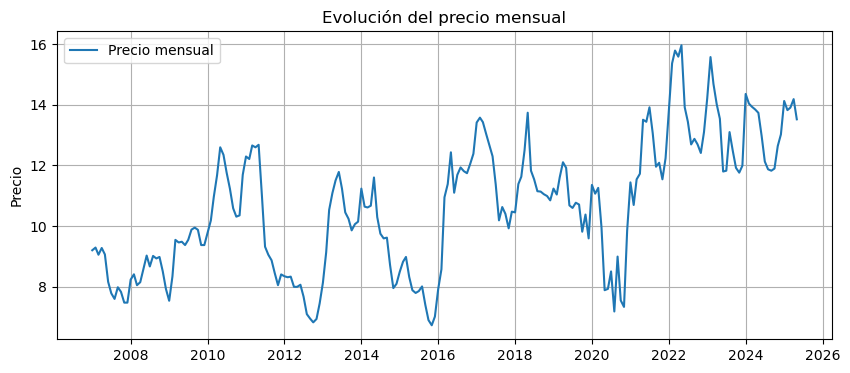

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(df, label="Precio mensual")
plt.title("Evolución del precio mensual")
plt.ylabel("Precio")
plt.grid(True)
plt.legend()
plt.show()

In [5]:

resultado = adfuller(df)
valor_p = resultado[1]
print(f"p: {valor_p}")

# Interpretar el resultado
if valor_p < 0.05:
    print("La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("La serie no es estacionaria (no se puede rechazar la hipótesis nula).")


p: 0.042205261601966436
La serie es estacionaria (se rechaza la hipótesis nula).


# Modelado

In [6]:
df_1 = filtrar_trimestre(df, trimestre=1)
df_2 = filtrar_trimestre(df, trimestre=2)
df_3 = filtrar_trimestre(df, trimestre=3)
df_4 = filtrar_trimestre(df, trimestre=4)

## Mejores hiperparámetros

In [7]:
p_range = range(0, 6)
d_range = range(0, 6)
q_range = range(0, 6)

orden_1 = grid_search_arima_aic(df_1, p_range, d_range, q_range)
orden_2 = grid_search_arima_aic(df_2, p_range, d_range, q_range)
orden_3 = grid_search_arima_aic(df_3, p_range, d_range, q_range)
orden_4 = grid_search_arima_aic(df_4, p_range, d_range, q_range)

c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [ ]:
print("Q1:", orden_1) #mejoró
print("Q2:", orden_2) #mejoró
print("Q3:", orden_3) #mejoró
print("Q4:", orden_4) #empeoró

Q1: ((0, 1, 0), 174.55153098874686)
Q2: ((4, 1, 3), 188.1815988240891)
Q3: ((2, 1, 4), 177.68851058334826)
Q4: ((2, 1, 1), 175.18670053631593)


In [13]:
# solo debemos agarrar el primer elemento de la tupla
orden_1 = orden_1[0]
orden_2 = orden_2[0]
orden_3 = orden_3[0]
orden_4 = orden_4[0]

In [ ]:
# orden_4 = (0, 1, 0) 

(2, 1, 1)

## Partir en train test

In [14]:
train_1, test_1 = partir_train_test(df_1, test_size=3)
train_2, test_2 = partir_train_test(df_2, test_size=3)
train_3, test_3 = partir_train_test(df_3, test_size=3)
train_4, test_4 = partir_train_test(df_4, test_size=3)

## Entrenamiento

In [15]:
modelo_fit_1 = ARIMA(train_1, order=orden_1).fit()
modelo_fit_2 = ARIMA(train_2, order=orden_2).fit()
modelo_fit_3 = ARIMA(train_3, order=orden_3).fit()
modelo_fit_4 = ARIMA(train_4, order=orden_4).fit()

c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

## Predicción

In [16]:
pred_1 = modelo_fit_1.forecast(steps=len(test_1))
pred_2 = modelo_fit_2.forecast(steps=len(test_2))
pred_3 = modelo_fit_3.forecast(steps=len(test_3))
pred_4 = modelo_fit_4.forecast(steps=len(test_4))

c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sofia\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sofia\anacon

# Evaluación

In [17]:
metrics_1 = errorMetrics(test_1.values, pred_1)
metrics_2 = errorMetrics(test_2.values, pred_2)
metrics_3 = errorMetrics(test_3.values, pred_3)
metrics_4 = errorMetrics(test_4.values, pred_4)


In [18]:
print("Q1:", metrics_1)
print("Q2:", metrics_2)
print("Q3:", metrics_3)
print("Q4:", metrics_4)


Q1: {'mse': 0.016511343025849574, 'mae': 0.10972067129629674, 'rmse': 0.12849647086924051, 'mape': 0.007836612283208364}
Q2: {'mse': 0.1285958203273241, 'mae': 0.29829309964031303, 'rmse': 0.35860259386586163, 'mape': 0.021573369302457318}
Q3: {'mse': 0.12722131714845564, 'mae': 0.3497840116678444, 'rmse': 0.3566809739086957, 'mape': 0.02931177629736459}
Q4: {'mse': 1.2606781204528312, 'mae': 0.9373745745507746, 'rmse': 1.1227992342591044, 'mape': 0.07312715389967787}


In [23]:
def plot_pred_vs_real(test, pred, trimestre):
    plt.figure(figsize=(10, 4))
    plt.plot(test.index, test, label="Real", marker='o')
    plt.plot(test.index, pred, label="Pronóstico", marker='x')
    plt.title(f"Predicción vs Real - Trimestre {trimestre}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.legend()
    plt.grid(True)
    plt.show()

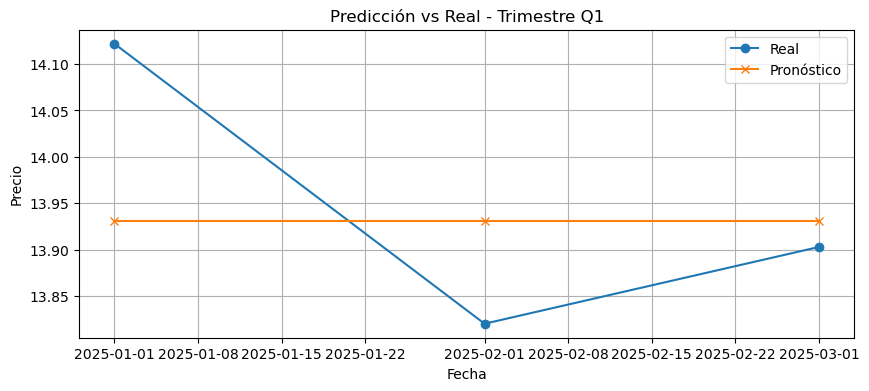

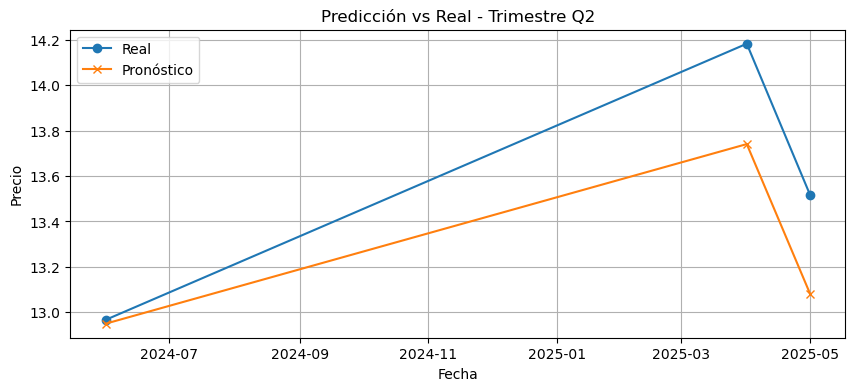

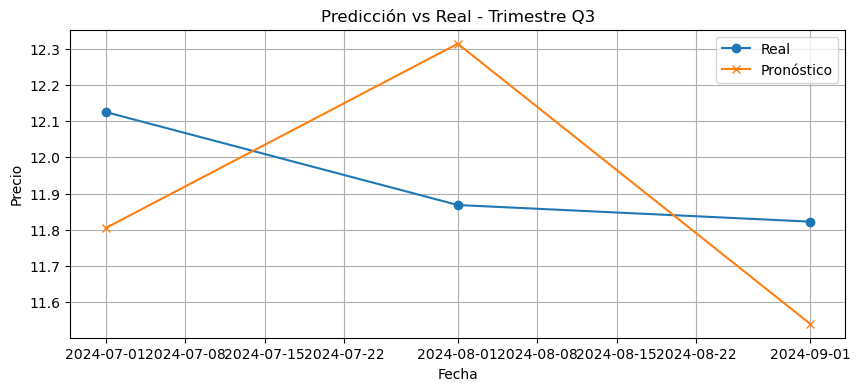

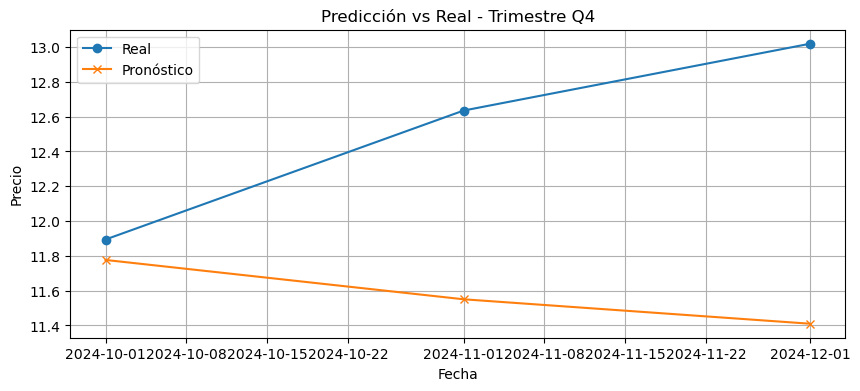

In [24]:
plot_pred_vs_real(test_1, pred_1, "Q1")
plot_pred_vs_real(test_2, pred_2, "Q2")
plot_pred_vs_real(test_3, pred_3, "Q3")
plot_pred_vs_real(test_4, pred_4, "Q4")
